In [1]:
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define paths and parameters
base_image_folder_path = '/local_dir'
train_image_folder = os.path.join(base_image_folder_path, 'Train_Images')
test_image_folder = os.path.join(base_image_folder_path, 'Test_Images')
vector_model_name = 'openpecha/tibetan_RoBERTa_S_e6'
dataset_name = 'ta4tsering/Lhasa_kanjur_transcription_datasets'
image_height = 64
image_width = 2048

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(vector_model_name)
model = AutoModel.from_pretrained(vector_model_name).to('cuda')

def load_transcription_vector(transcription):
    inputs = tokenizer(transcription, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    vector = torch.mean(outputs.last_hidden_state, dim=1).squeeze()
    return vector.cpu().numpy()

def load_image(folder_path, filename):
    img_path = os.path.join(folder_path, filename)
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((image_width, image_height))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img.astype(np.float32)

def process_example(folder_path, example):
    transcription = example['label']
    filename = example['filename']
    if filename in local_filenames:
        vector = load_transcription_vector(transcription)
        image = load_image(folder_path, filename)
        return vector, image
    else:
        return None

def create_tf_dataset(split_name, folder_path):
    # Get the list of local filenames
    global local_filenames
    local_filenames = set(os.listdir(folder_path))

    # Load the dataset
    dataset = load_dataset(dataset_name, split=split_name)

    # Process the dataset using a for-loop
    vectors = []
    images = []

    for example in tqdm(dataset):
        result = process_example(folder_path, example)
        if result is not None:
            vector, image = result
            vectors.append(vector)
            images.append(image)

    # Convert lists to numpy arrays
    vectors = np.array(vectors, dtype=np.float32)
    images = np.array(images, dtype=np.float32)
    print("hi")
    # Create TensorFlow datasets directly from NumPy arrays
    tf_dataset = tf.data.Dataset.from_tensor_slices((vectors, images)).batch(32).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return tf_dataset

# Create datasets
#train_dataset = create_tf_dataset('train', train_image_folder)
eval_dataset = create_tf_dataset('eval', train_image_folder)
test_dataset = create_tf_dataset('test', test_image_folder)

2024-07-20 10:05:26.488126: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 10:05:26.500880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 10:05:26.504820: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 10:05:26.515060: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of RobertaModel were not initialized fro

hi


2024-07-20 10:07:24.718294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43184 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9
100%|██████████| 16640/16640 [01:41<00:00, 164.30it/s]


hi


NameError: name 'train_dataset' is not defined

In [2]:
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.models import Model

# Define the autoencoder model
def build_autoencoder(input_shape, vector_shape):
    # Encoder
    text_input = Input(shape=vector_shape)
    x = Dense(1024, activation='relu')(text_input)
    x = Dense(512, activation='relu')(x)
    encoded = Dense(256, activation='relu')(x)

    # Decoder
    x = Dense(512, activation='relu')(encoded)
    x = Dense(1024, activation='relu')(x)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)

    # Autoencoder model
    autoencoder = Model(text_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Define the input shape and vector shape
input_shape = (image_height, image_width, 1)
vector_shape = (768,)  # Adjust based on the actual vector size from your text embeddings

# Build the autoencoder model
autoencoder = build_autoencoder(input_shape, vector_shape)
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 131072)         │   134,348,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 64, 2048, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,449,280 (520.51 MB)

 Trainable params: 136,449,280 (520.51 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the autoencoder on the train dataset and validate on the eval dataset
autoencoder.fit(test_dataset, validation_data=eval_dataset, epochs=50, verbose=1)

Epoch 1/50


I0000 00:00:1721470223.083567  127996 service.cc:146] XLA service 0x7f88b4004db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721470223.083606  127996 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2024-07-20 10:10:23.136263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 10:10:23.257506: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-07-20 10:10:26.283474: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_490', 8 bytes spill stores, 8 bytes spill loads

2024-07-20 10:10:26.486378: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in fu

 14/520 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1889

I0000 00:00:1721470229.905283  127996 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


520/520 ━━━━━━━━━━━━━━━━━━━━ 25s 26ms/step - loss: 0.1105 - val_loss: 0.1020
Epoch 2/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1019 - val_loss: 0.1019
Epoch 3/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1018 - val_loss: 0.1018
Epoch 4/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.1017 - val_loss: 0.1017
Epoch 5/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1017 - val_loss: 0.1017
Epoch 6/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1016 - val_loss: 0.1017
Epoch 7/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1015 - val_loss: 0.1018
Epoch 8/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.1015 - val_loss: 0.1017
Epoch 9/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1014 - val_loss: 0.1017
Epoch 10/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1014 - val_loss: 0.1016
Epoch 11/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1013 - val_loss: 0.1018
Epoch 12/50
520/520 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Original Image 1


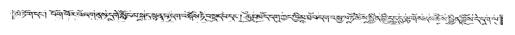

Reconstructed Image 1


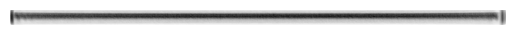

Original Image 2


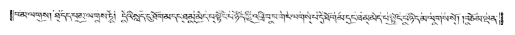

Reconstructed Image 2


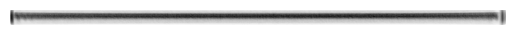

Original Image 3


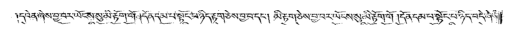

Reconstructed Image 3


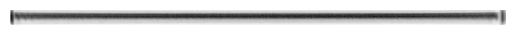

2024-07-20 10:14:31.679831: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
import matplotlib.pyplot as plt
# Function to plot image
def plot_image(image_array):
    plt.imshow(image_array.squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

# Inference on the test dataset
for vectors, images in test_dataset.take(1):
    reconstructed_images = autoencoder.predict(vectors)
    
    # Plot original and reconstructed images
    for i in range(3):
        print(f"Original Image {i+1}")
        plot_image(images[i].numpy())
        print(f"Reconstructed Image {i+1}")
        plot_image(reconstructed_images[i])